Extracted 17 rows with 4 columns (excluding 2nd and 3rd).


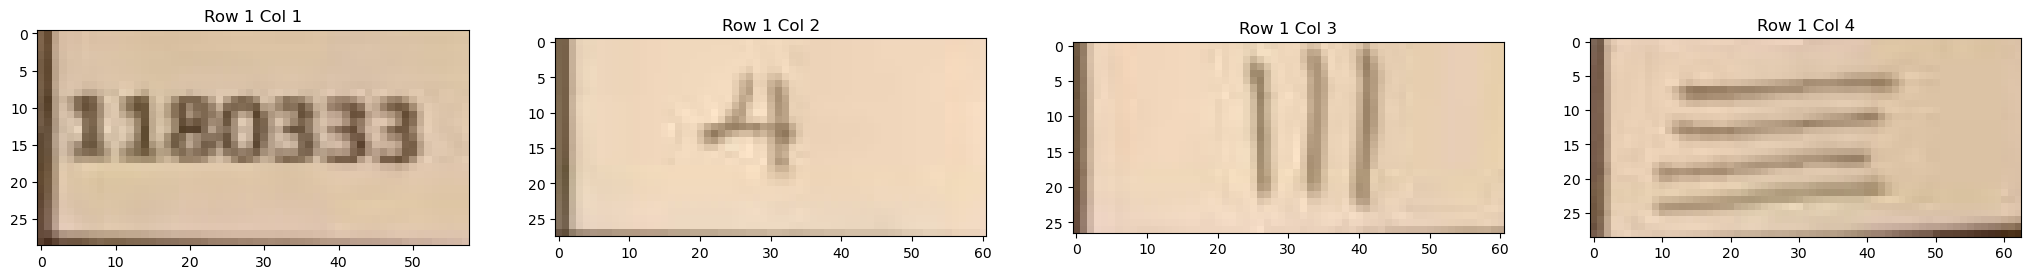

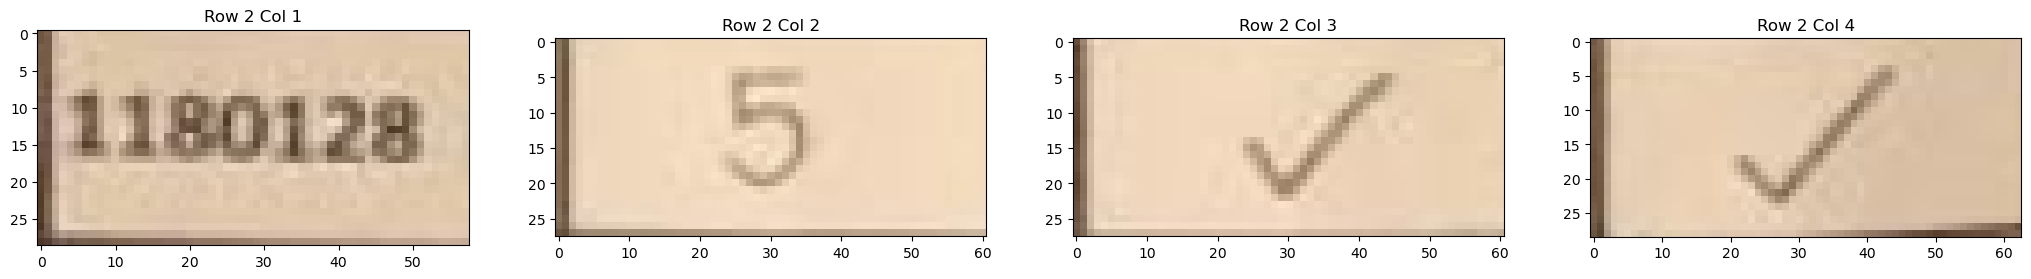

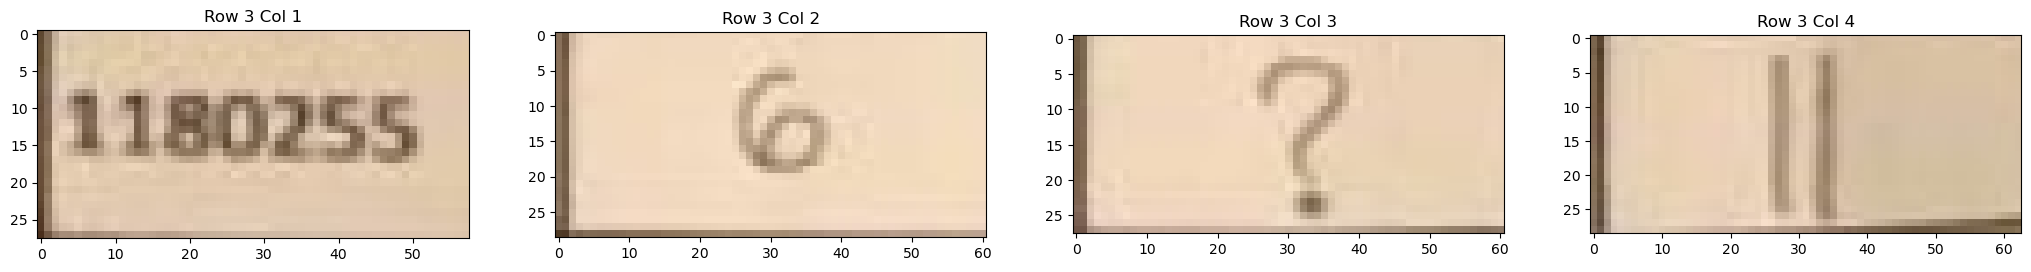

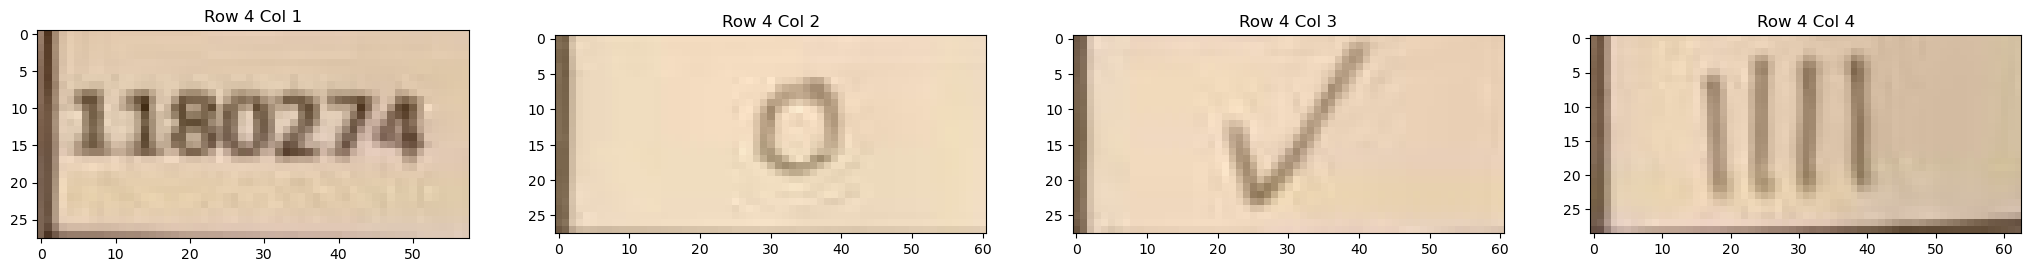

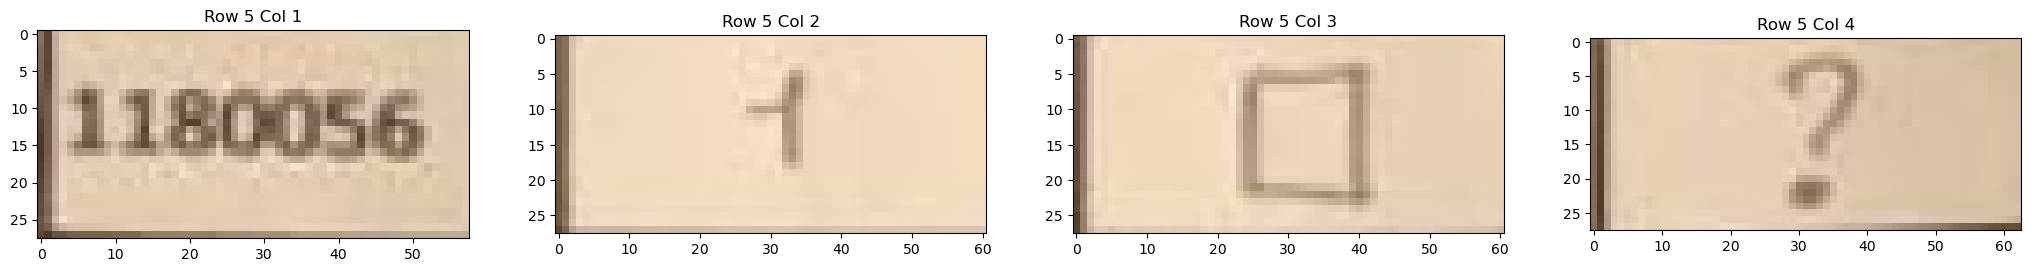

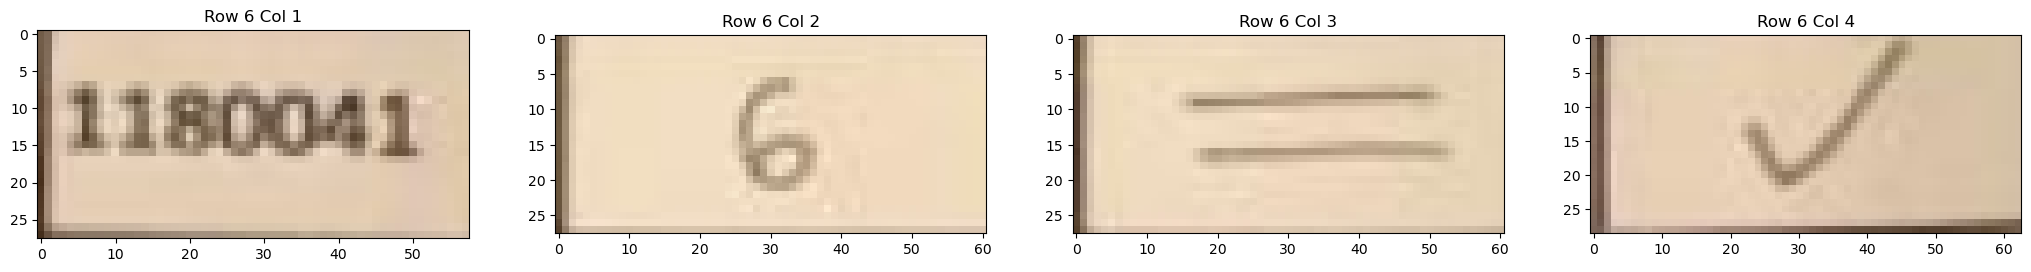

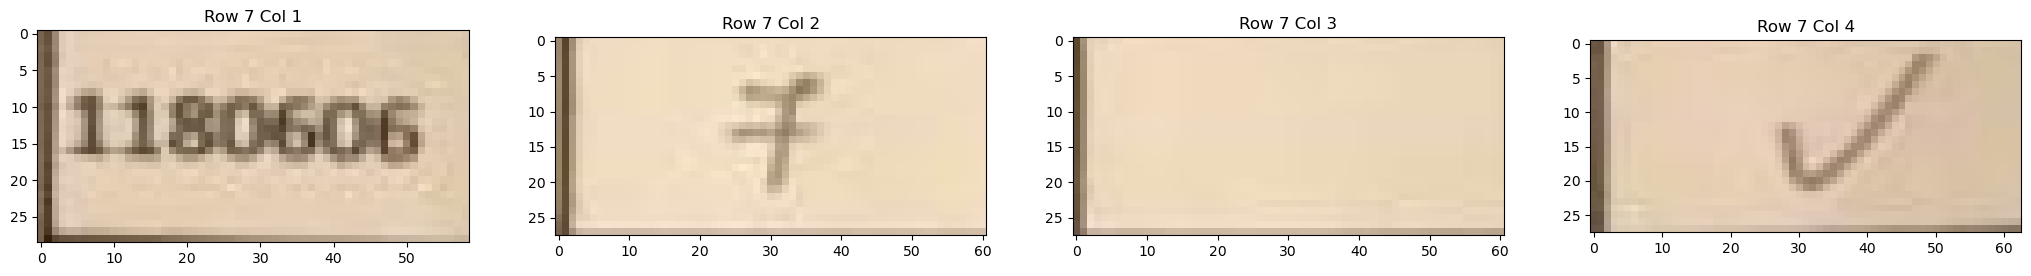

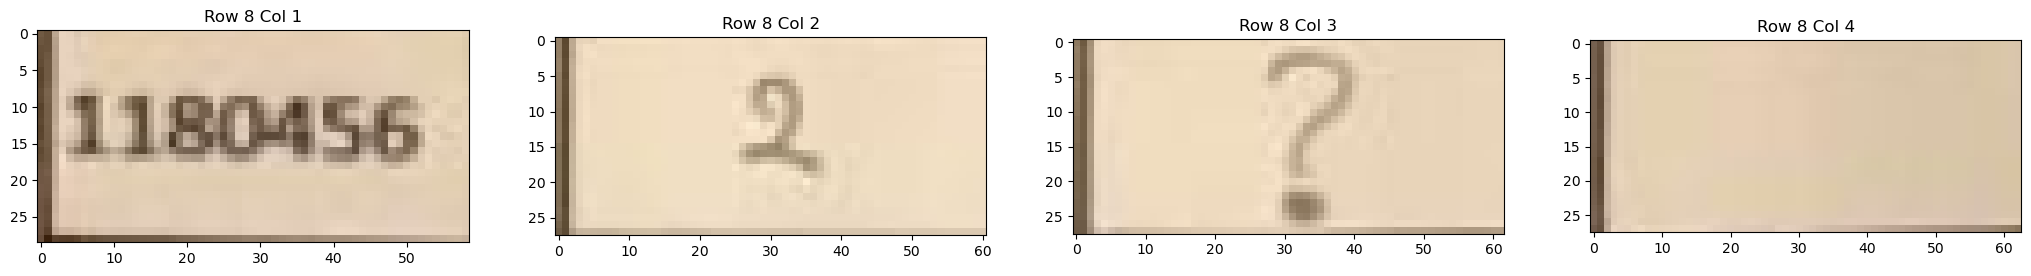

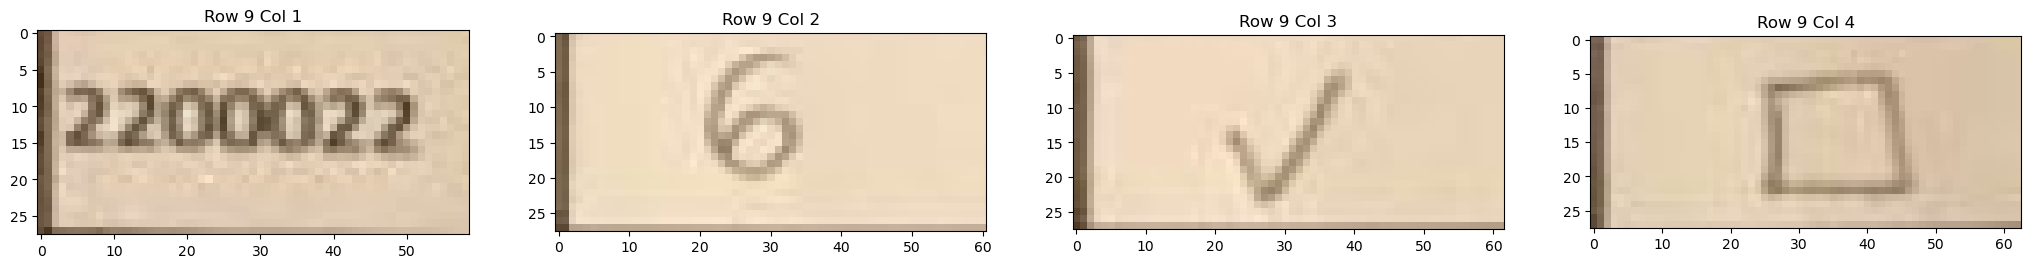

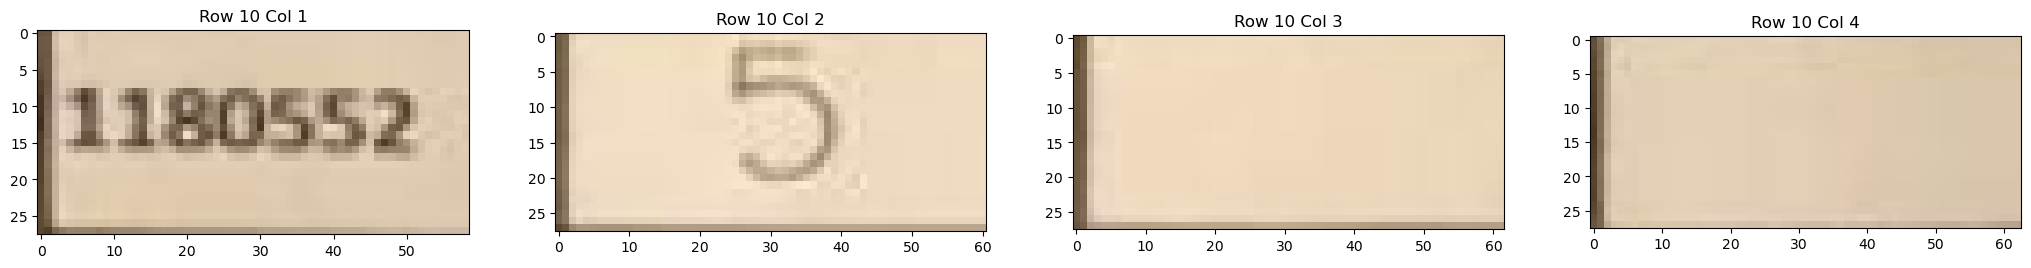

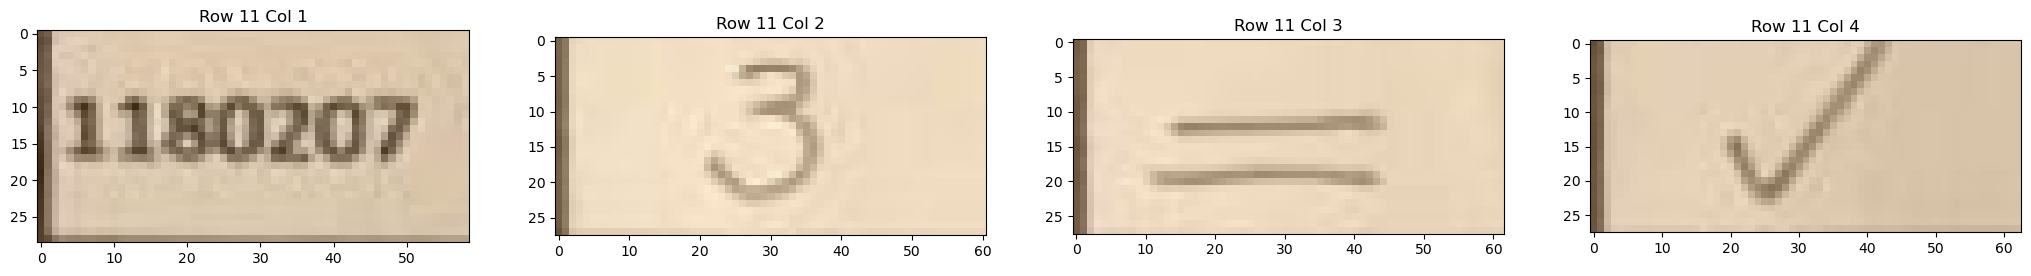

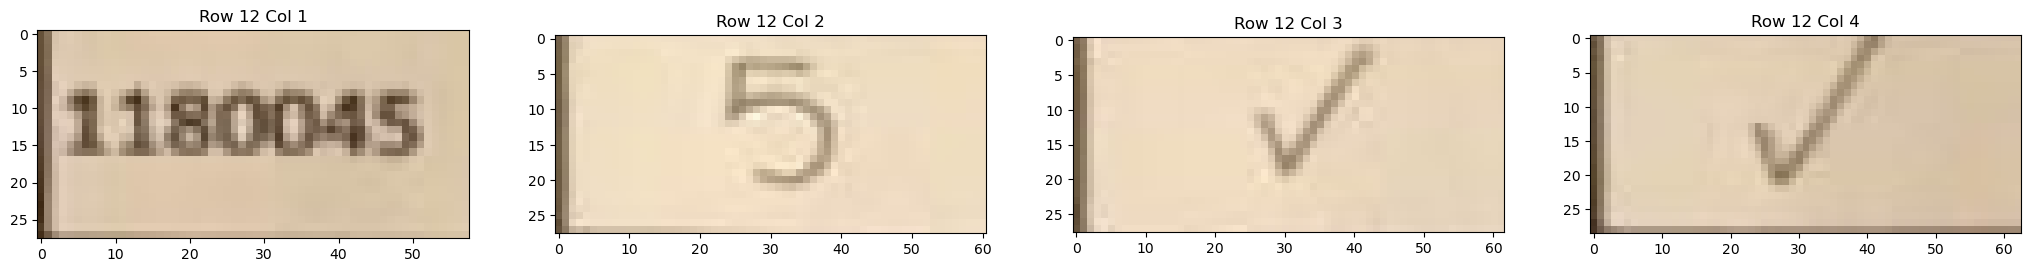

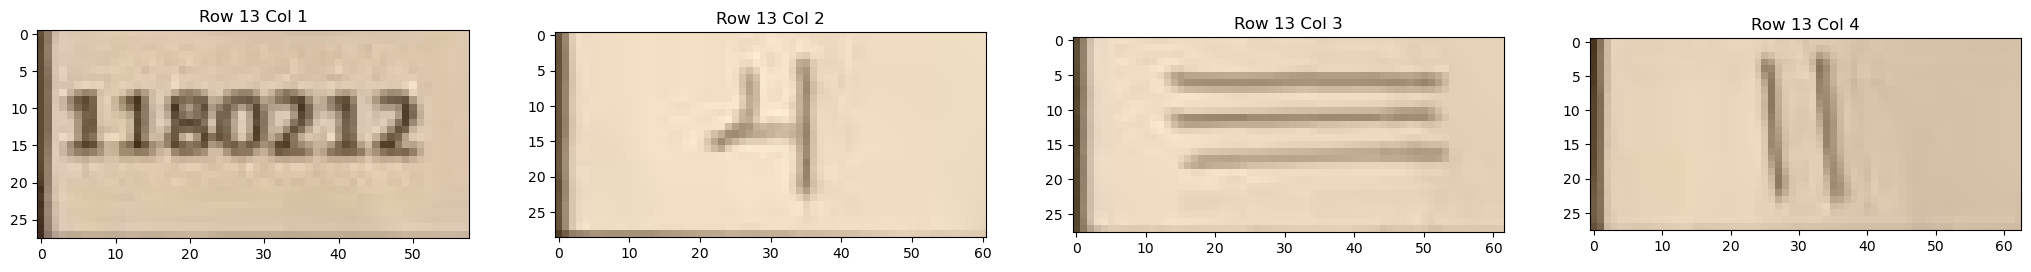

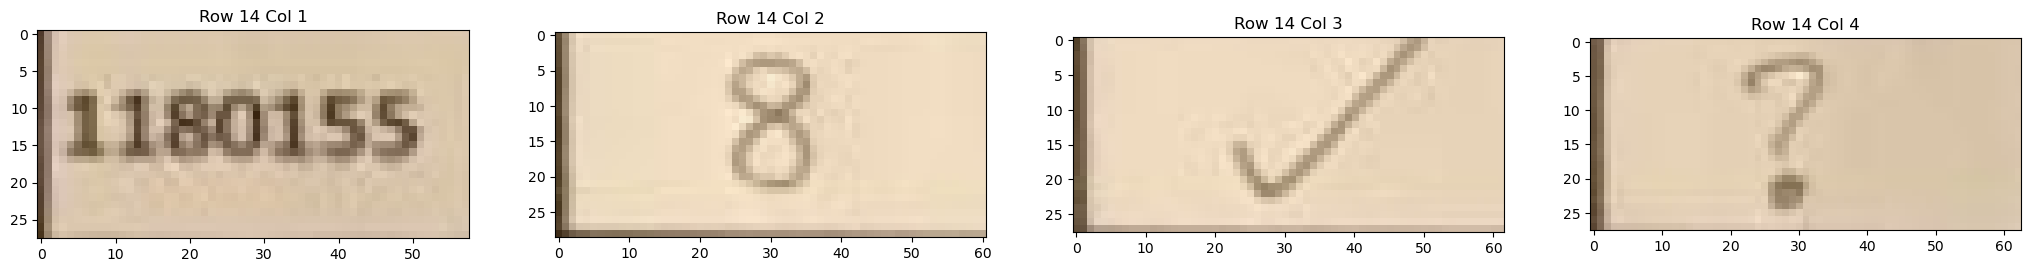

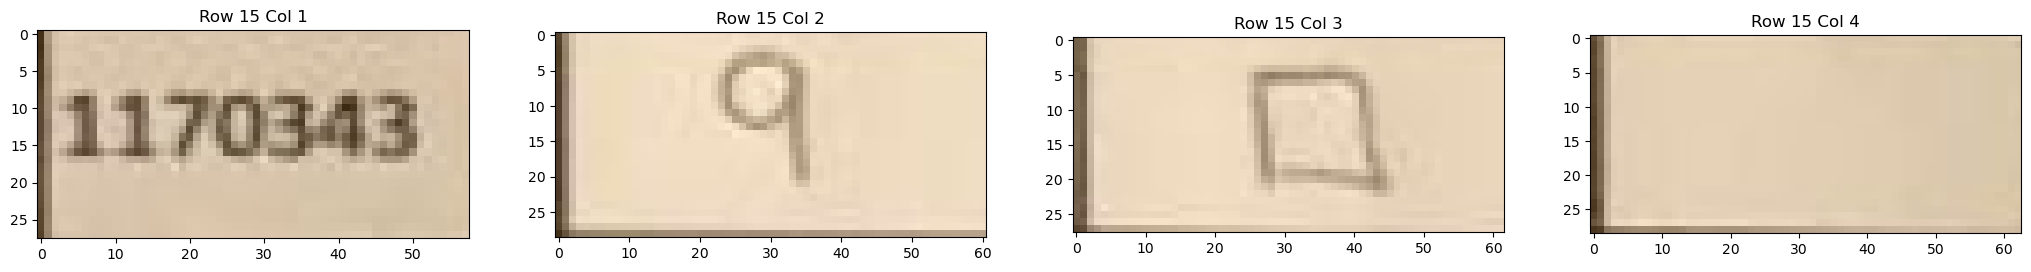

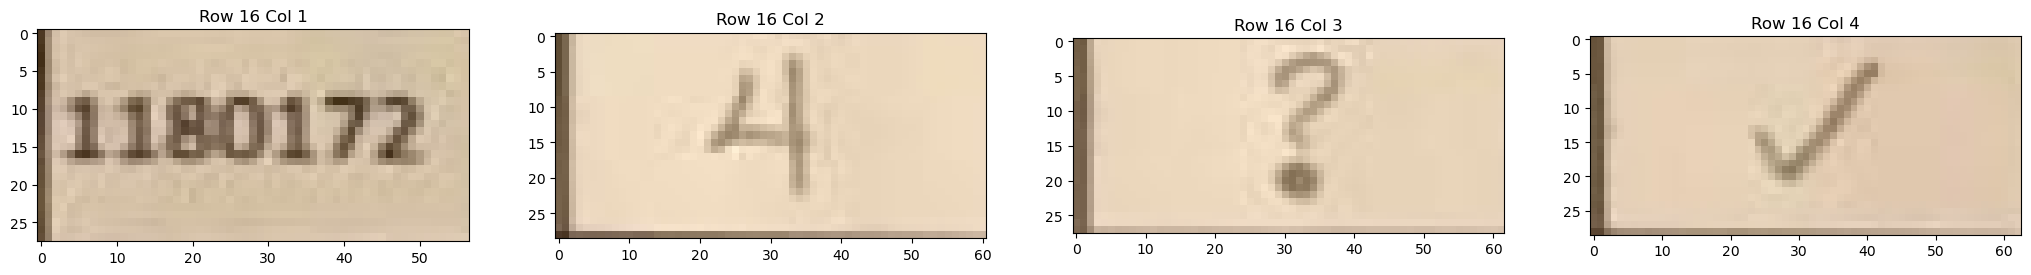

([[array([[[126, 100,  75],
           [102,  76,  51],
           [189, 163, 138],
           ...,
           [219, 196, 164],
           [220, 197, 165],
           [221, 198, 166]],
   
          [[127, 101,  76],
           [102,  76,  51],
           [189, 163, 138],
           ...,
           [218, 195, 163],
           [219, 196, 164],
           [219, 196, 165]],
   
          [[126, 100,  75],
           [104,  79,  54],
           [192, 166, 142],
           ...,
           [220, 197, 165],
           [221, 198, 166],
           [221, 198, 167]],
   
          ...,
   
          [[101,  75,  59],
           [128, 102,  87],
           [188, 162, 146],
           ...,
           [223, 198, 171],
           [224, 199, 171],
           [224, 199, 171]],
   
          [[101,  75,  59],
           [104,  78,  63],
           [142, 116, 101],
           ...,
           [222, 196, 174],
           [222, 196, 173],
           [223, 197, 174]],
   
          [[ 90,  64,  48],
        

In [ ]:
# from modules.utils import *
import matplotlib.pyplot as plt
import imutils
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog
import skimage.io as io
import pytesseract
import numpy as np
import cv2
import os
from sklearn import svm
import pickle
from sklearn.model_selection import train_test_split
import random
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion, binary_dilation
import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import PatternFill
def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

def reorderPoints(points):

    points = points.reshape((4, 2))
    newPoints = np.zeros((4, 1, 2), dtype=np.int32)
    add = points.sum(1)

    newPoints[0] = points[np.argmin(add)]
    newPoints[3] = points[np.argmax(add)]
    diff = np.diff(points, axis=1)
    newPoints[1] = points[np.argmin(diff)]
    newPoints[2] = points[np.argmax(diff)]

    return newPoints

def ExtractTableWithCells(ImagePath):
    # =========================================Read Image==========================================
    img_BGR = cv2.imread(ImagePath, cv2.IMREAD_COLOR)
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)
    
    # =========================================PreProcessing==========================================
    Blurred_image_Median = cv2.medianBlur(img_gray, 5)
    Edged_Image = cv2.Canny(Blurred_image_Median, 180, 255)
    kernel = np.ones((5, 5), np.uint8)
    Dilated_img = cv2.dilate(Edged_Image, kernel, iterations=2)
    Erroded_img = cv2.erode(Dilated_img, kernel, iterations=1)
    
    # =========================================Detect and Warp the Table==========================================
    contrours_img = np.copy(Erroded_img)
    contours, _ = cv2.findContours(contrours_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    biggest_contour = None

    for contour in contours:
        area = cv2.contourArea(contour)
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        if area > max_area and len(approx) == 4:  # Check for rectangular shape
            max_area = area
            biggest_contour = approx

    if biggest_contour is None:
        print("No table detected.")
        return None, None, False

    # Reorder points and warp the perspective
    biggestContour = reorderPoints(biggest_contour)
    imgHeight, imgWidth = img_gray.shape
    pts1 = np.float32(biggestContour)
    pts2 = np.float32([[0, 0], [imgWidth, 0], [0, imgHeight], [imgWidth, imgHeight]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    WarpedGrayImage = cv2.warpPerspective(img_gray, matrix, (imgWidth, imgHeight))
    WarpedColoredImage = cv2.warpPerspective(img_RGB, matrix, (imgWidth, imgHeight))

    # =========================================Threshold and Extract Grid Lines==========================================
    _, img_bin = cv2.threshold(WarpedGrayImage, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_bin = 255 - img_bin  # Invert colors

    # Extract vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, img_bin.shape[1] // 150))
    vertical_lines = cv2.dilate(cv2.erode(img_bin, vertical_kernel, iterations=10), vertical_kernel, iterations=10)

    # Extract horizontal lines
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (img_bin.shape[1] // 150, 1))
    horizontal_lines = cv2.dilate(cv2.erode(img_bin, hor_kernel, iterations=10), hor_kernel, iterations=15)

    # Combine vertical and horizontal lines
    grid_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    grid_lines = cv2.erode(~grid_lines, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)), iterations=3)
    _, grid_lines = cv2.threshold(grid_lines, 128, 255, cv2.THRESH_BINARY)

    # =========================================Find and Sort Contours==========================================
    contours, _ = cv2.findContours(grid_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    boundingBoxes = [cv2.boundingRect(c) for c in contours]
    (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes), key=lambda b: (b[1][1], b[1][0])))

    # Filter valid rectangles
    boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 8 and h > 15:  # Filter noise
            boxes.append([x, y, w, h])

    # Group boxes into rows and columns
    rows = []
    current_row = []
    previous_y = boxes[0][1]
    row_height_threshold = np.mean([h for _, _, _, h in boxes]) / 2  # Threshold to group rows

    for box in boxes:
        if abs(box[1] - previous_y) > row_height_threshold:
            rows.append(current_row)
            current_row = []
        current_row.append(box)
        previous_y = box[1]

    if current_row:
        rows.append(current_row)

    # =========================================Crop Cells into a Matrix (excluding columns 2 and 3)==========================================
    cropped_matrix = []
    for row in rows:
        row.sort(key=lambda b: b[0])  # Sort left-to-right
        if len(row) >= 6:  # Ensure there are 6 columns
            cropped_row = []
            # Exclude the second and third columns by skipping index 1 and 2 (0-indexed)
            for i in [0, 3, 4, 5]:  # Select 1st, 4th, 5th, and 6th rectangles (skip 2nd and 3rd)
                x, y, w, h = row[i]
                x=x-5
                cropped = WarpedColoredImage[y:y + h, x:x + w]
                cropped_row.append(cropped)
            cropped_matrix.append(cropped_row)

    # =========================================Display and Return Results==========================================
    print(f"Extracted {len(cropped_matrix)} rows with 4 columns (excluding 2nd and 3rd).")

    cropped_matrix =cropped_matrix[1:]
    for i, row in enumerate(cropped_matrix):
        titles = [f"Row {i+1} Col {j+1}" for j in range(len(row))]
        show_images(row, titles)

    return cropped_matrix, WarpedColoredImage, True



Extracted 17 rows with 4 columns (excluding 2nd and 3rd).


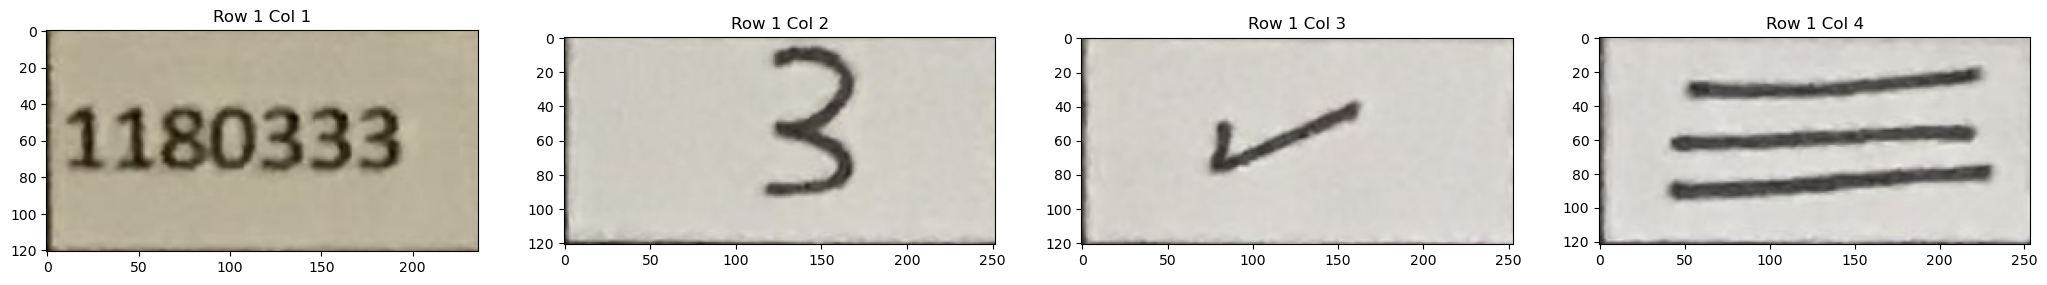

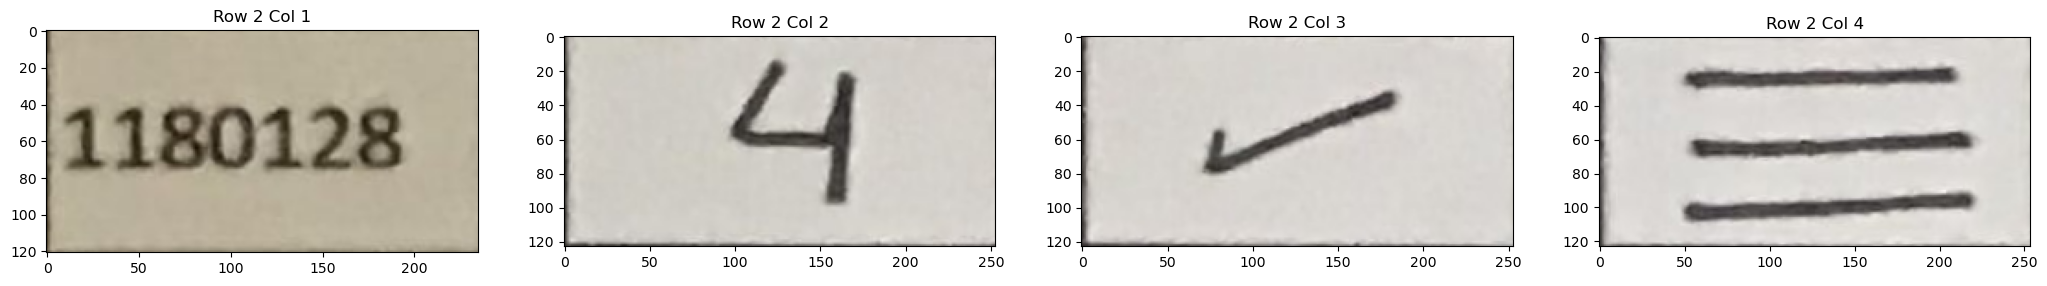

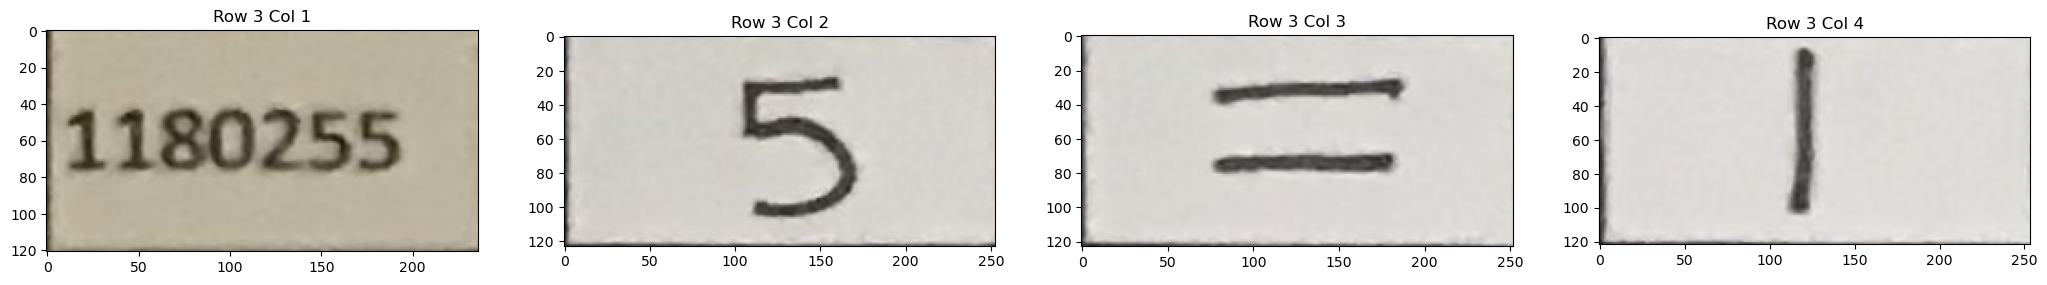

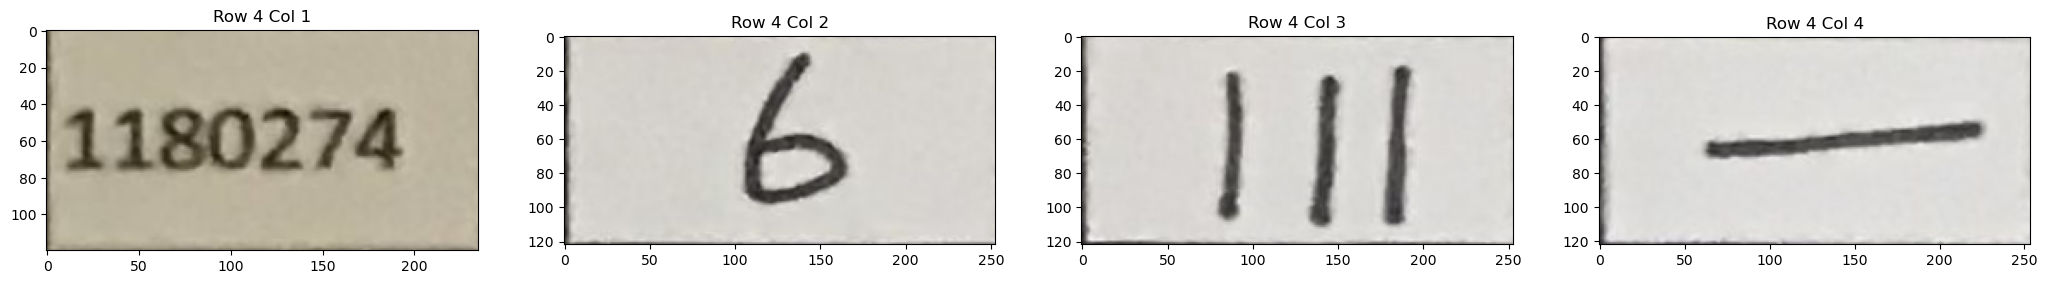

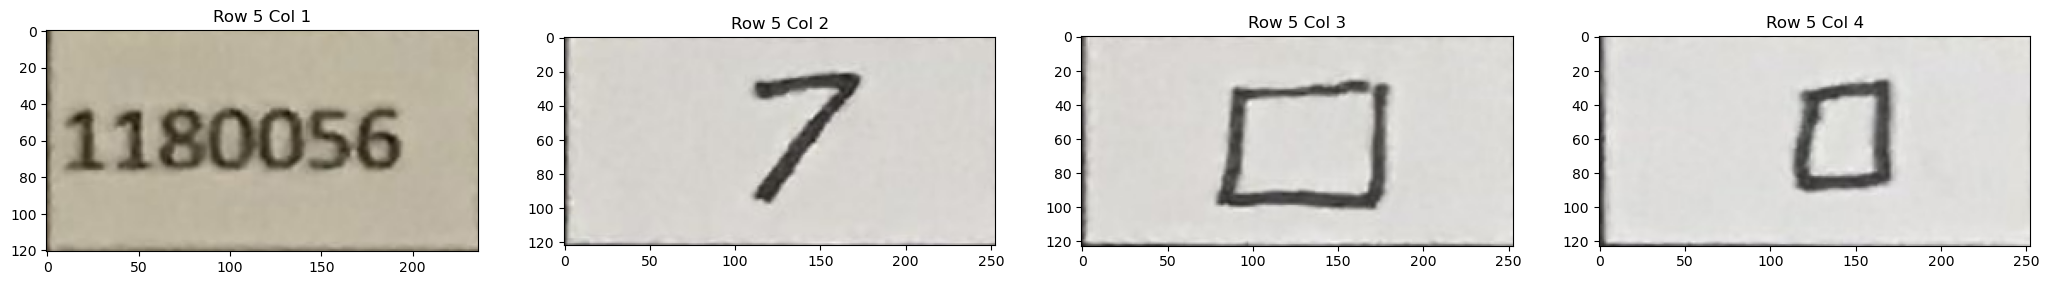

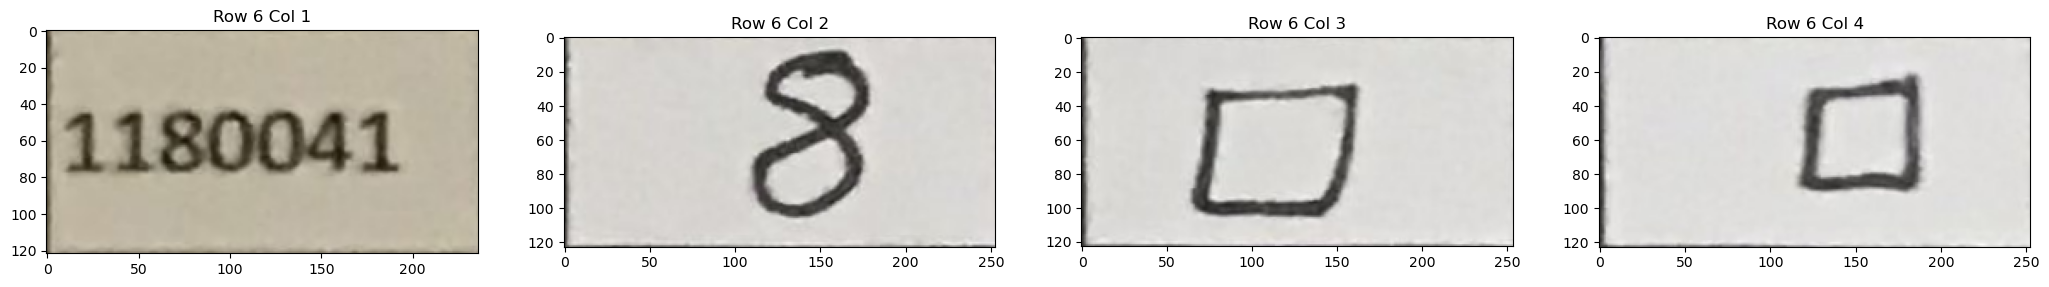

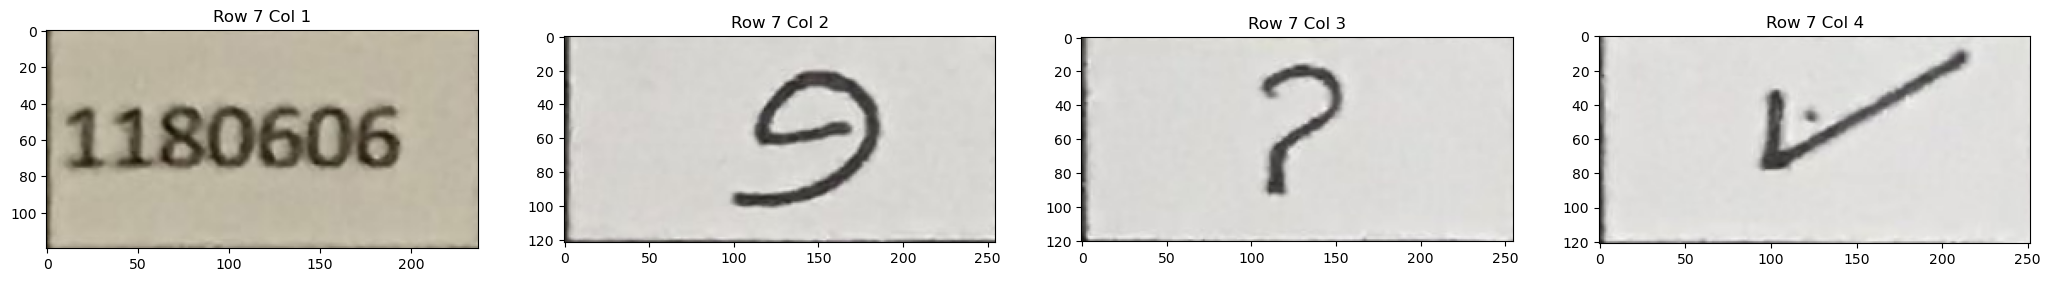

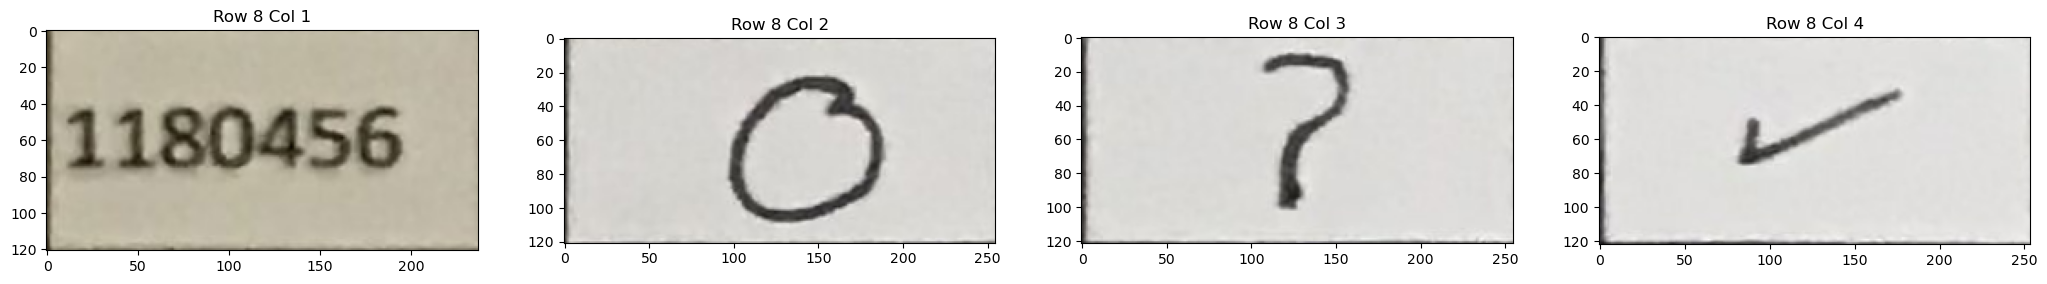

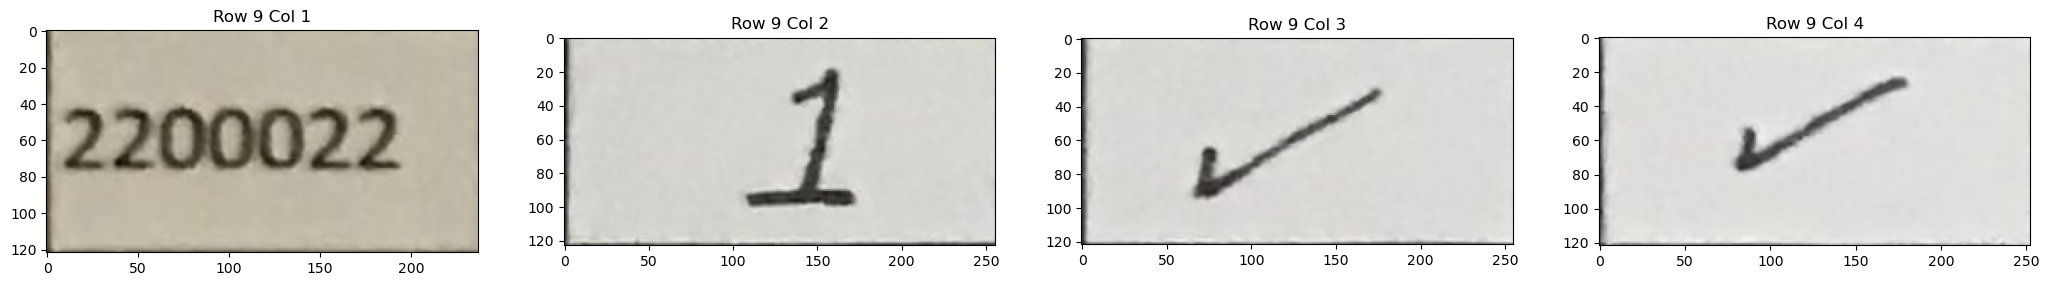

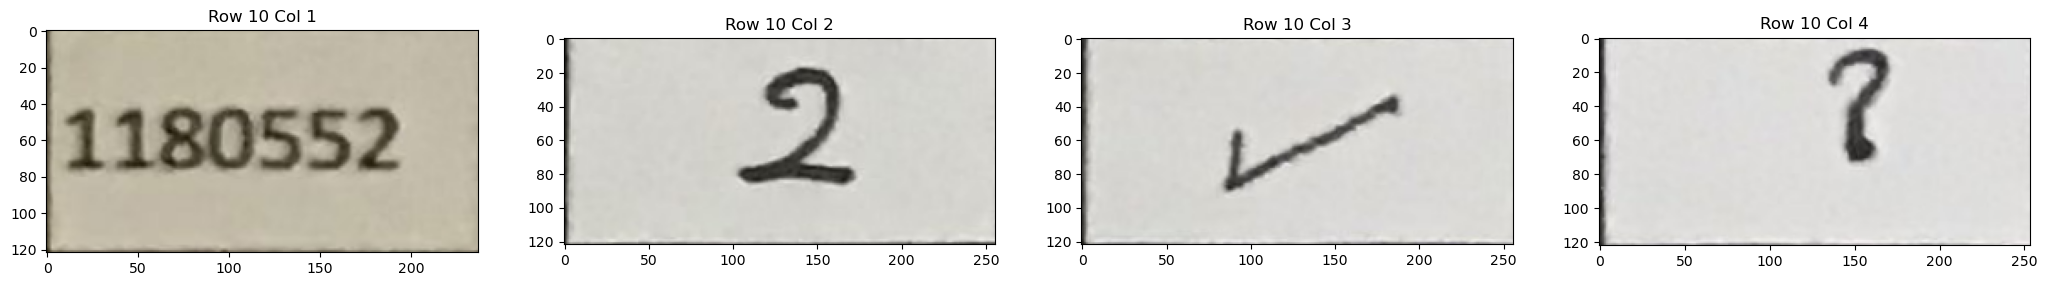

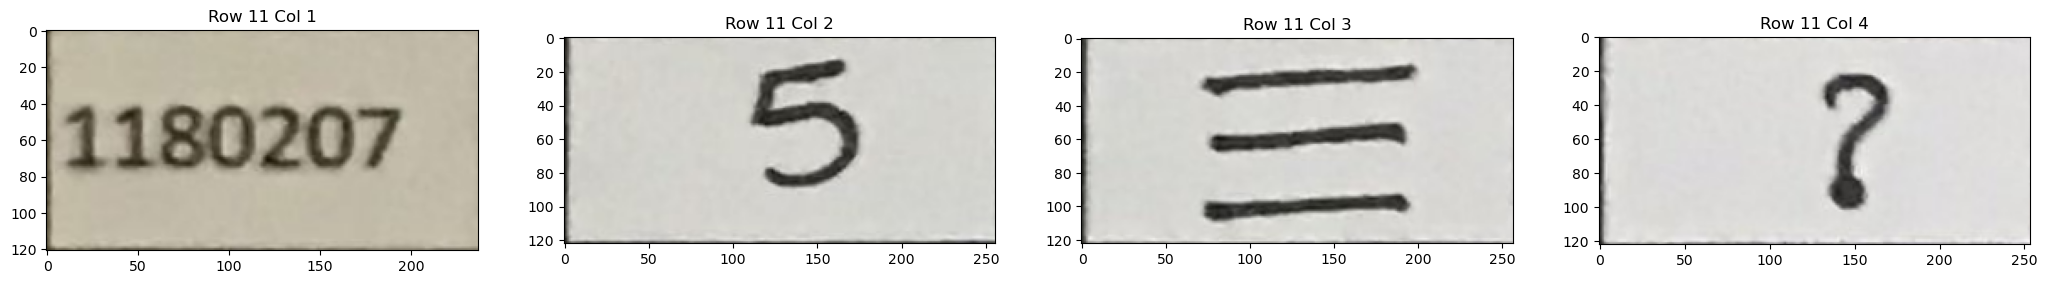

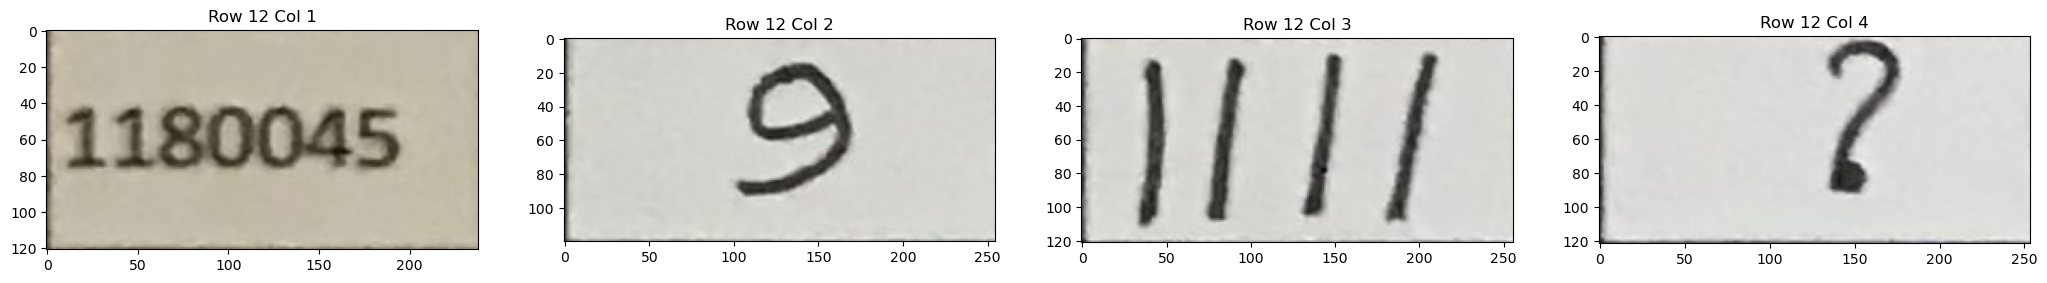

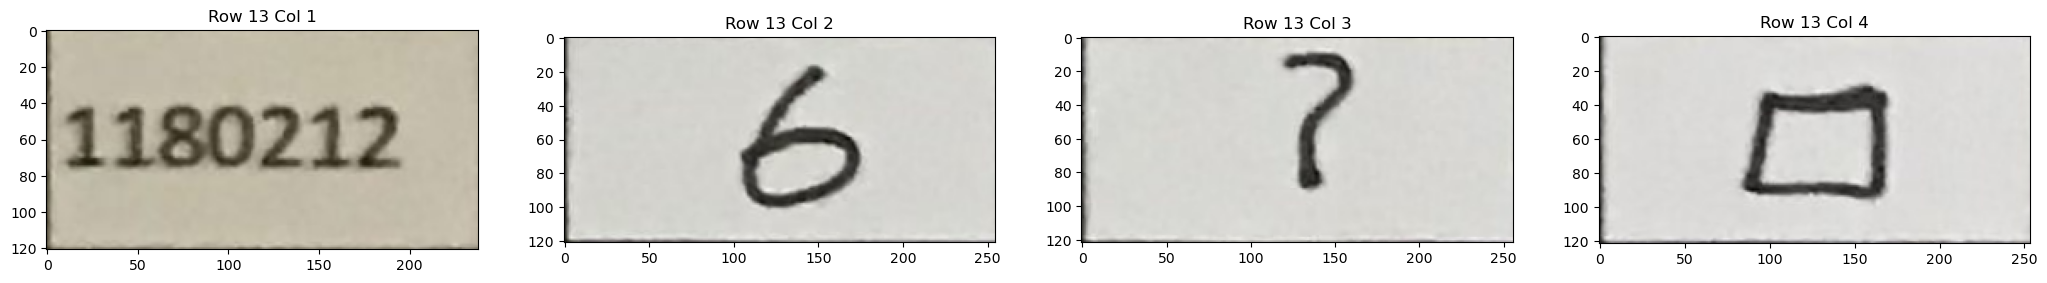

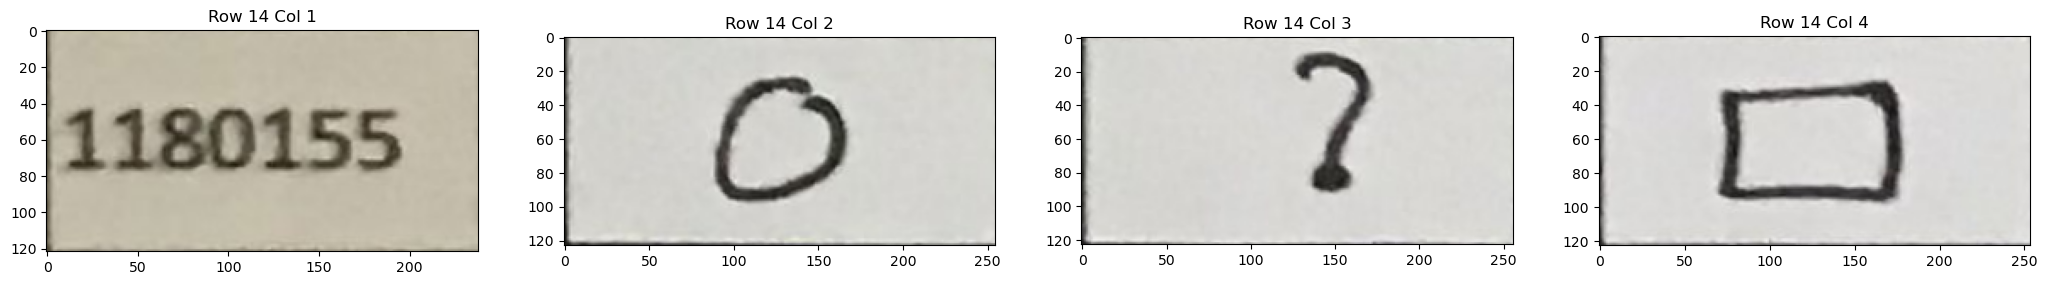

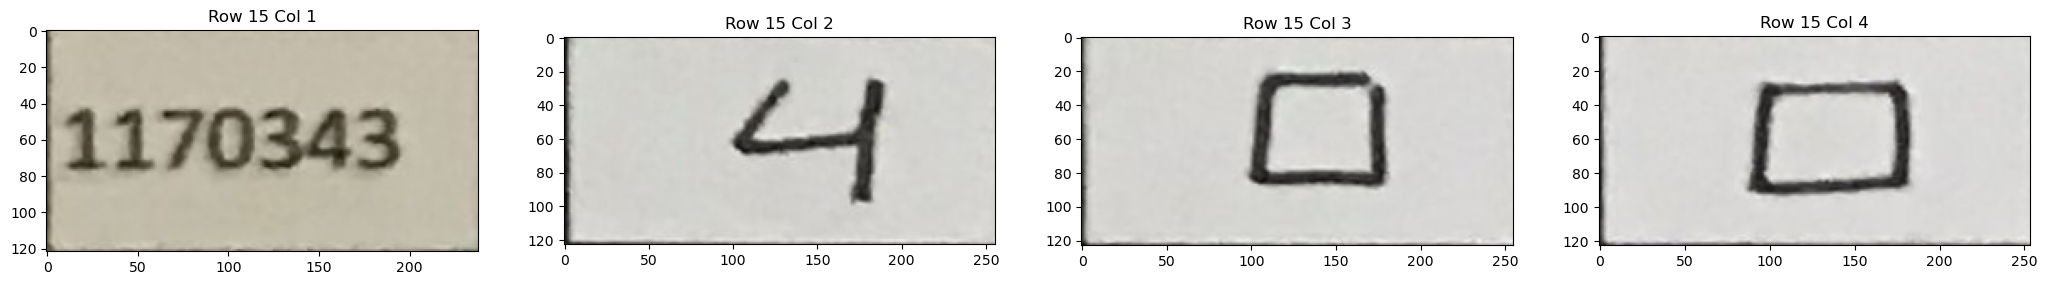

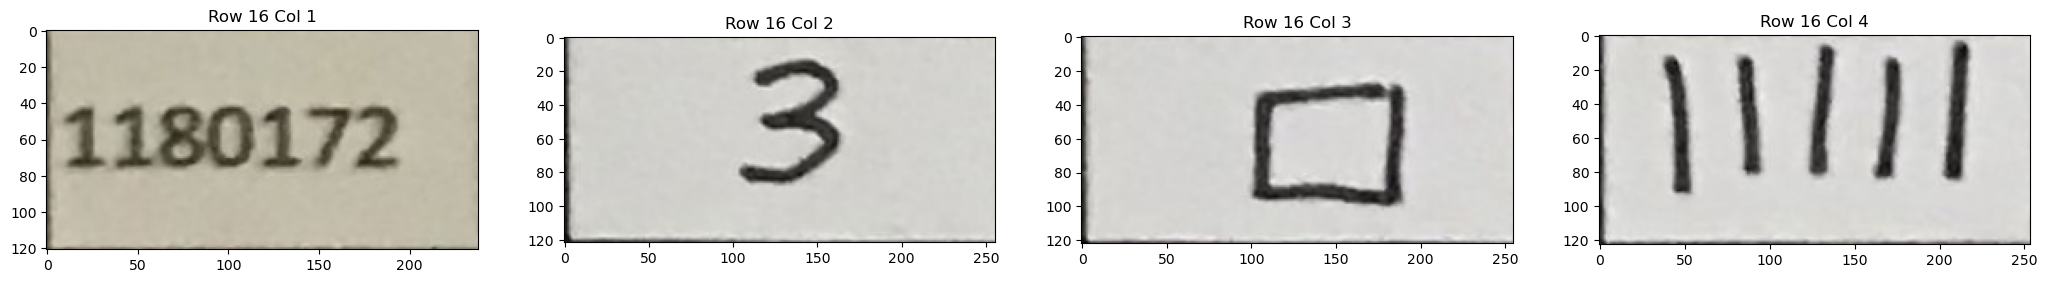

([[array([[[ 76,  65,  45],
           [ 99,  88,  67],
           [124, 113,  91],
           ...,
           [174, 163, 141],
           [172, 161, 139],
           [174, 163, 141]],
   
          [[ 68,  57,  37],
           [ 93,  82,  61],
           [124, 113,  91],
           ...,
           [183, 172, 150],
           [181, 170, 148],
           [179, 168, 146]],
   
          [[ 62,  51,  31],
           [ 88,  77,  57],
           [124, 113,  91],
           ...,
           [186, 175, 153],
           [185, 174, 152],
           [182, 171, 149]],
   
          ...,
   
          [[ 33,  22,   3],
           [ 65,  54,  34],
           [106,  95,  76],
           ...,
           [180, 172, 151],
           [181, 173, 152],
           [180, 172, 151]],
   
          [[ 25,  14,   0],
           [ 54,  43,  25],
           [ 91,  80,  60],
           ...,
           [164, 156, 135],
           [168, 160, 139],
           [168, 160, 139]],
   
          [[ 32,  21,   5],
        

In [13]:
ExtractTableWithCells("../Data set/grade sheet/8.jpg")